In [41]:
import numpy as np
import ctypes
from numpy.linalg import lstsq
from numba import jit, njit
import matplotlib.pyplot as plt

import pickle

from ref_project import get_projection_matrix
from c_project import get_matrix
from FORBILD import forbild_sinogram, forbild_sinogram_noquad

In [51]:
import importlib
import FORBILD

importlib.reload(FORBILD)

from FORBILD import forbild_sinogram, forbild_sinogram_noquad, discrete_phantom

In [3]:
nx = 100
ny = 100
nnp = 128
nu = 128
lsd = 78.125
lso = 39.0625
dx = 0.25
dy = 0.25
du = 0.62

In [4]:
def forward_with_matrix(img, mat):
    img = img.reshape(nx*ny, 1)
    mat = mat.reshape(nnp*nu, nx*ny)

    proj = mat @ img

    return proj.reshape(nnp, nu)

def backward_from_projection(sino, mat):
    sino = sino.reshape(nnp*nu, 1)
    mat = mat.reshape(nnp*nu, nx*ny)
    
    img, residual, _, _ = lstsq(mat, sino, rcond=None)

    print("Residual: ", residual)

    return img.reshape(nx, ny)

0 0 0.0
0 1 0.0
0 2 0.0
0 3 0.0
0 4 0.0
0 5 0.12549213133005388
0 6 0.30933887361078893
0 7 0.40989771820154597
0 8 0.4825589834804773
0 9 0.5388559800597204
0 10 0.5836557872842538
0 11 0.61955974447037
0 12 0.6481423809587397
0 13 0.6704290189080166
0 14 0.6871157300484094
0 15 0.698682749517745
0 16 0.7054572216450905
0 17 0.7076489738613376
0 18 0.7053702648331734
0 19 0.6986446621567353
0 20 0.6874071117086958
0 21 0.6714951125846809
0 22 0.6506287039031347
0 23 0.6243736436508627
0 24 5.6046414428359785
0 25 9.61004449556128
0 26 11.732096047214924
0 27 13.854073891743106
0 28 15.649363638565553
0 29 17.2201048791156
0 30 12.430679793550771
0 31 13.061720420542244
0 32 13.654615301735959
0 33 14.2128892979955
0 34 14.735111045302236
0 35 15.222905397266382
0 36 15.6849559971125
0 37 16.121227442861112
0 38 16.530477789533965
0 39 16.91590188576656
0 40 17.27887817133269
0 41 17.614099951832266
0 42 17.93254915388901
0 43 18.23487457003917
0 44 18.518802966554016
0 45 18.784468380

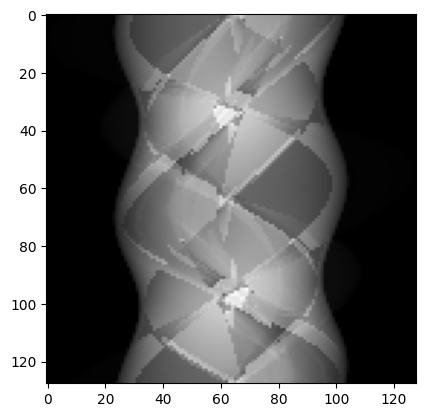

In [52]:
proj = forbild_sinogram_noquad(nnp, nu, du, lsd, lso, True)

plt.imshow(proj, cmap='gray')

In [53]:
# ref_mat = get_projection_matrix(nx, ny, nnp, nu, dx, dy, du, lsd, lso)

# ref_mat = np.transpose(ref_mat, (2, 3, 0, 1))

# pickle.dump(ref_mat, open("ref.mat", 'wb'))

ref_mat = pickle.load(open("ref.mat", 'rb'))

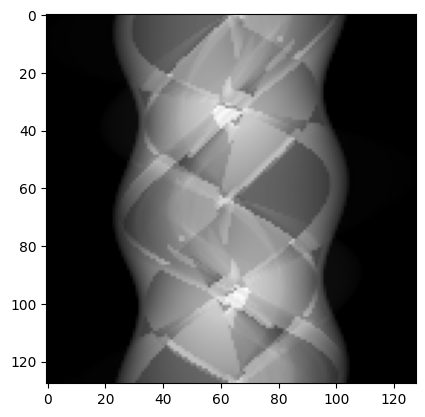

In [6]:
proj = np.load(open('fb.dat', 'rb'))

plt.imshow(proj, cmap='gray')

In [54]:
img_sample_1 = backward_from_projection(proj, ref_mat)

Residual:  [29597.648]


2549.0749011130347 -2308.890173982369 0.9038100157679136


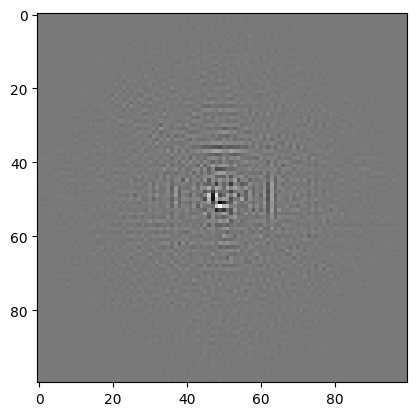

In [55]:
print(np.max(img_sample_1), np.min(img_sample_1), np.mean(img_sample_1))

plt.imshow(img_sample_1, cmap='gray')

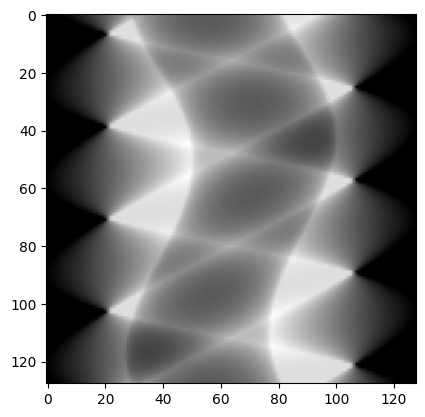

In [31]:
img = np.ones((nx, ny), dtype=np.float64)

for i in range(nx):
    for j in range(ny):
        if (i-40)**2 + (j-40)**2 <= 900:
            img[i,j] = 0

sino = forward_with_matrix(img, ref_mat)

plt.imshow(sino, cmap='gray')

In [34]:
print(np.min(proj), np.max(proj), np.mean(proj))
print(np.min(sino), np.max(sino), np.mean(sino))

0.0 52.0337714463477 15.016768826813832
0.0 28.82765082865987 12.106025981940714


In [32]:
ret = backward_from_projection(sino, ref_mat)


Residual:  [1.129e-24]


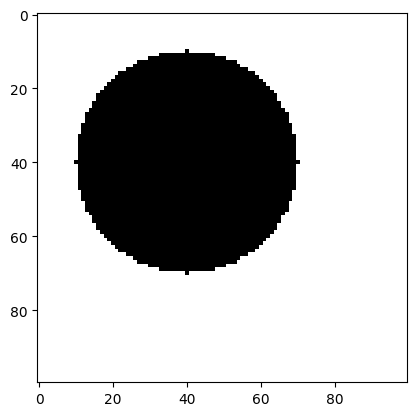

In [39]:
plt.imshow(ret, cmap='gray')

In [16]:
mat = np.zeros((nnp, nu, nx, ny), dtype=np.float64)

get_matrix(nx, ny, nnp, nu, dx, dy, du, lsd, lso, mat)

In [10]:
img2 = backward_from_projection(proj, mat)

print(np.max(img2), np.min(img2))

Residual:  [3.796]
0.9754636971914448 -1.0017945147235117


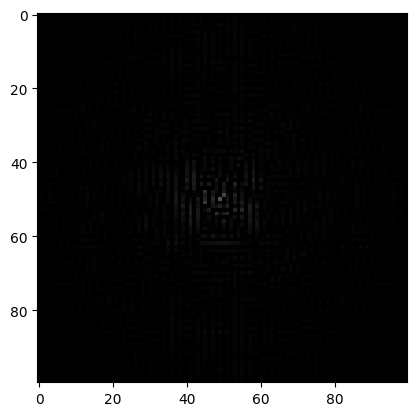

In [36]:
plt.imshow(img2, cmap='bone')